# Load data

<https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data>

In [1]:
import re

import gender_guesser.detector as detector
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import sage

In [2]:
# Load data
df = sage.datasets.airbnb()

# Sample rows
df.head(5)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaT,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [3]:
# Categorical features
categorical_columns = ["neighbourhood_group", "neighbourhood", "room_type"]
for column in categorical_columns:
    df[column] = pd.Categorical(df[column]).codes

In [4]:
# Exclude outliers (top 0.5%)
df = df[df["price"] < df["price"].quantile(0.995)]

In [5]:
# Features derived from name
df["name_length"] = df["name"].apply(lambda x: len(x))
df["name_isupper"] = df["name"].apply(lambda x: int(x.isupper()))
df["name_words"] = df["name"].apply(lambda x: len(re.findall(r"\w+", x)))

In [6]:
# Host gender guess
guesser = detector.Detector()
df["host_gender"] = df["host_name"].apply(lambda x: guesser.get_gender(x.split(" ")[0]))
df["host_gender"] = pd.Categorical(df["host_gender"]).codes

In [7]:
# Number of days since last review
most_recent = df["last_review"].max()
df["last_review"] = (most_recent - df["last_review"]).dt.days
df["last_review"] = (df["last_review"] - df["last_review"].mean()) / df[
    "last_review"
].std()
df["last_review"] = df["last_review"].fillna(-5)

In [8]:
# Missing values
df["reviews_per_month"] = df["reviews_per_month"].fillna(0)

In [9]:
# Normalize other numerical features
df["number_of_reviews"] = (
    df["number_of_reviews"] - df["number_of_reviews"].mean()
) / df["number_of_reviews"].std()
df["availability_365"] = (df["availability_365"] - df["availability_365"].mean()) / df[
    "availability_365"
].std()
df["name_length"] = (df["name_length"] - df["name_length"].mean()) / df[
    "name_length"
].std()

In [10]:
# Normalize latitude and longitude
df["latitude"] = (df["latitude"] - df["latitude"].mean()) / df["latitude"].std()
df["longitude"] = (df["longitude"] - df["longitude"].mean()) / df["longitude"].std()

In [11]:
# Drop columns
df = df.drop(["id", "host_id", "host_name", "name"], axis=1)

In [12]:
# New sample rows
df.head(5)

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,name_length,name_isupper,name_words,host_gender
0,1,108,-1.492033,-0.440795,1,149,1,-0.321948,-0.034852,0.21,6,1.922931,-0.276169,0,7,2
1,2,127,0.452497,-0.687792,0,225,1,0.484307,-0.552366,0.38,2,1.846815,-1.513431,0,3,1
2,2,94,1.467544,0.219381,1,150,3,-0.523512,-5.000000,0.00,1,1.922931,-0.180995,1,6,1
3,1,41,-0.802204,-0.167581,0,89,1,5.523401,-0.661188,4.64,1,0.621350,-0.561691,0,5,5
4,2,61,1.274978,0.174098,0,80,10,-0.321948,-0.109819,0.10,1,-0.855298,1.056268,0,8,1


In [13]:
# Rearrange columns
target_col = "price"
cols = df.columns.tolist()
del cols[cols.index(target_col)]
cols.append(target_col)
feature_names = cols[:-1]
df = df[cols]

# Split data
train, test = train_test_split(
    df.values, test_size=int(0.1 * len(df.values)), random_state=0
)
train, val = train_test_split(
    train, test_size=int(0.1 * len(df.values)), random_state=0
)
Y_train = train[:, -1:].copy()
Y_val = val[:, -1:].copy()
Y_test = test[:, -1:].copy()
train = train[:, :-1].copy()
val = val[:, :-1].copy()
test = test[:, :-1].copy()

# Train model

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [15]:
batch_size = 32

# Prepare training data
train_dataset = tf.data.Dataset.from_tensor_slices((train, Y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Prepare validation data
val_dataset = tf.data.Dataset.from_tensor_slices((val, Y_val))
val_dataset = val_dataset.batch(batch_size)

# Get model
model = keras.Sequential(
    [
        layers.Dense(256, activation="relu", input_shape=(train.shape[1],)),
        layers.Dense(256, activation="relu"),
        layers.Dense(1),
    ],
    name="airbnb_model",
)

# Instantiate optimizer
optimizer = keras.optimizers.Adam(learning_rate=1e-3)

# Instantiate loss function
loss_fn = keras.losses.MeanSquaredError()

# Prepare metrics
train_acc_metric = keras.metrics.MeanSquaredError()
val_acc_metric = keras.metrics.MeanSquaredError()


# Training and validation utils
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        preds = model(x)
        loss_value = loss_fn(y, preds)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc_metric.update_state(y, preds)
    return loss_value


@tf.function
def test_step(x, y):
    preds = model(x)
    val_acc_metric.update_state(y, preds)

In [16]:
epochs = 50

for epoch in range(epochs):
    # Iterate over data minibatches
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        loss_value = train_step(x_batch_train, y_batch_train)

    # Display metrics at the end of each epoch
    train_acc = train_acc_metric.result()
    train_acc_metric.reset_states()

    # Run validation loop at the end of each epoch
    for x_batch_val, y_batch_val in val_dataset:
        test_step(x_batch_val, y_batch_val)

    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()

# For classification (which is not the case here): see
# https://github.com/iancovert/sage/blob/master/sage/utils.py#L36,
# as output activations should already be applied properly.
# probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

In [17]:
print("Training MSE: %.4f" % (float(train_acc),))
print("Validation MSE: %.4f" % (float(val_acc),))

Training MSE: 6702.4839
Validation MSE: 7224.5664


# Calculate individual feature importance

In [18]:
# Setup and calculate
imputer = sage.MarginalImputer(model, test[:512])
estimator = sage.PermutationEstimator(imputer, "mse")
sage_values = estimator(test, Y_test)

Setting up imputer for keras model, assuming that any necessary output activations are applied properly. If not, please set up keras.Sequential with keras.layers.Softmax()


  0%|          | 0/1 [00:00<?, ?it/s]

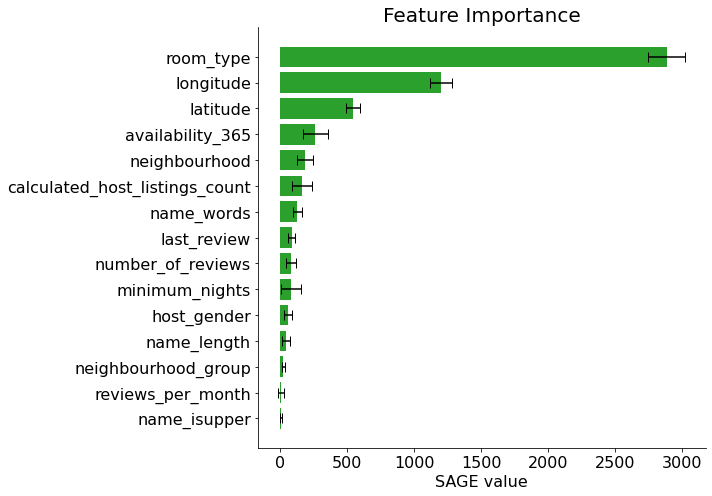

In [19]:
# Plot results
sage_values.plot(feature_names)

# Calculate grouped feature importance

In [20]:
# Feature groups
feature_groups = group_names = {
    "location (grouped)": [
        "latitude",
        "longitude",
        "neighbourhood",
        "neighbourhood_group",
    ],
    "name (grouped)": ["name_words", "name_length", "name_isupper"],
    "reviews (grouped)": ["last_review", "reviews_per_month", "number_of_reviews"],
    "host (grouped)": ["host_gender", "calculated_host_listings_count"],
    "availability": ["availability_365"],
    "room_type": ["room_type"],
}
group_names = [group for group in feature_groups]
for col in feature_names:
    if np.all([col not in group[1] for group in feature_groups.items()]):
        group_names.append(col)

# Group indices
groups = []
for _, group in feature_groups.items():
    ind_list = []
    for feature in group:
        ind_list.append(cols.index(feature))
    groups.append(ind_list)

In [21]:
# Setup and calculate
imputer = sage.GroupedMarginalImputer(model, test[:512], groups)
estimator = sage.PermutationEstimator(imputer, "mse")
sage_values = estimator(test, Y_test)

Setting up imputer for keras model, assuming that any necessary output activations are applied properly. If not, please set up keras.Sequential with keras.layers.Softmax()


  0%|          | 0/1 [00:00<?, ?it/s]

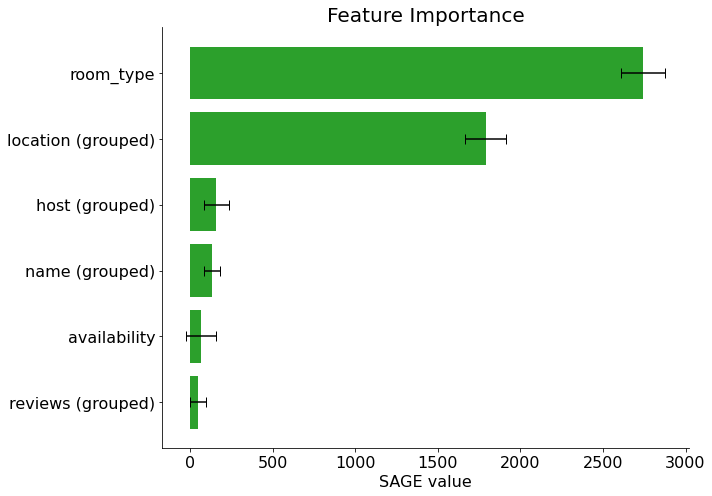

In [22]:
# Plot results
sage_values.plot(group_names)